# 1) Setup

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import math
import scipy as sp
from scipy import stats

from copy import copy
import time
import yaml
import networkx as nx

import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import pymongo
from pymongo import MongoClient
from datetime import datetime
from datetime import timedelta
print("done")

done


In [3]:
#import functions from python files

#1) data import & filtering
from get_data import *
from filter_data1 import *
from filter_data2 import *        #counts n_robots on an edge
from filter_data3 import *
from filter_data4 import *        #alternative to filter_data2 - counts robots on all adjacent edges too
from filter_data5 import *        #alternative to filter_data4 - counts robots on edges adjacent to target node
from select_data import *
from select_data_edge import *

#2) Bayesian optimisation of Lognormal model
from Gamma import *
from Lognormal import *
from Gaussian import *
from Gaussian_broadcast import *
from Normal_Gamma import *

from Normal_Gamma_bayes import *
from Normal_Gamma_bayes_update import *
from Gaussian_ml import *              # for comparison


#3) Measures of error
from integrate_pdf import *
from integrate import *
from integrate_trapezium import *
from integrate_simpson import *

from error_crps import *
from error_crps_single import *
from error_ks import *
from error_ks_2samples import *

#4) Clustering edges
from underscore_prefix import *
from underscore_suffix import *

from ks_between_edges import *
from distances_ks import *
from distances_length import *
from distances_connections import *
from distances_connections2 import *

from get_context import *
from get_adjacent import *
from augment_with_context import *

from draw_graph import *
from draw_clusters import *
from draw_count import *

from optimum_clusters import *

#5) Generalise between edges
from crps_between_edges import *
from mergefit_crps_ks import *
from mergefit_meancrps_ks import *
from mergefit_augment_stats import *

from mergefit import *
from train_regression import *



print("done")

done


In [4]:
# load from excel (see FILTER.ipynb)
df_walmart_random = pd.read_excel("filtered_walmart_random.xlsx")
df_walmart_random = df_walmart_random.loc[:,["origin", "target", "edge_id", "operation_time", "n_robots"]]

df_walmart_targeted = pd.read_excel("filtered_walmart_targeted.xlsx")
df_walmart_targeted = df_walmart_targeted.loc[:,["origin", "target", "edge_id", "operation_time", "n_robots"]]

df_blenheim_random = pd.read_excel("filtered_blenheim_random.xlsx")
df_blenheim_random = df_blenheim_random.loc[:,["origin", "target", "edge_id", "operation_time", "n_robots"]]

df_blenheim_targeted = pd.read_excel("filtered_blenheim_targeted.xlsx")
df_blenheim_targeted = df_blenheim_targeted.loc[:,["origin", "target", "edge_id", "operation_time", "n_robots"]]
print("done")

done


# 2) Effect of Congestion on Clustering
- Use Blenheim data

## 2a) Clustering based on spatial features

### 2ai) Edge length
- 1 cluster

In [104]:
#Create matrix of edge_length distances
context = get_context("blenheim_map.yaml")
length_matrix, length_edges = distances_length(context)

Time taken: 0.13414978981018066 secs
Time taken:  0.011967897415161133 secs


Optimum no. of clusters: 11
Max silhouette coeff: 0.9999999437551995


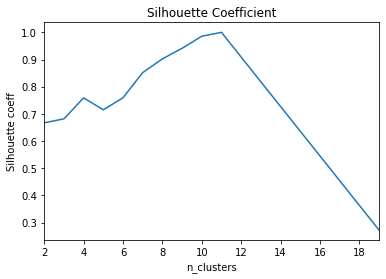

In [105]:
n_clusters, s_list = optimum_clusters(length_matrix, max_clusters = 20, method = "ss")

In [107]:
#for edge_length difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(s_list)], affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( length_matrix )
print(labels)
labels = np.zeros(len(length_edges)) + 1
length_clusters = pd.DataFrame(index = np.arange(len(length_edges)),columns = ["edge_id", "cluster_id"])
length_clusters["edge_id"] = length_edges
length_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[ 8  7  9 10  5  3  9  6  4  7  6  5  8  2  1  0  2 10  1  3  4  0]
11 clusters


no. of edges: 22
no. of colors: 22


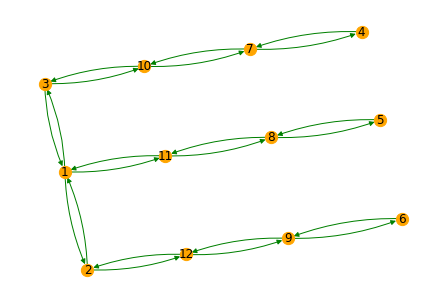

In [108]:
G = draw_clusters("blenheim_map.yaml", length_clusters)
plt.savefig("clusters_length_blenheim.svg")

### 2aii) Connections

In [109]:
#Create matrix of connections_diff distances
context = get_context("blenheim_map.yaml")
connections_matrix, connections_edges = distances_connections2(context)

Time taken: 0.07630324363708496 secs
Time taken:  0.01595592498779297 secs


Optimum no. of clusters: 3
Max silhouette coeff: 1.0


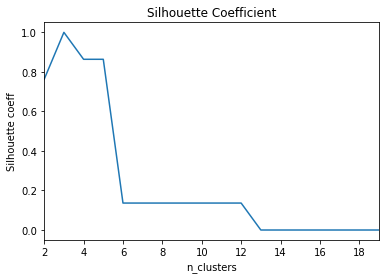

In [110]:
n_clusters, s_list = optimum_clusters(connections_matrix, max_clusters = 20, method = "ss")

In [111]:
#for connections difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(s_list)], affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( connections_matrix )
print(labels)
connections_clusters = pd.DataFrame(index = np.arange(len(connections_edges)),columns = ["edge_id", "cluster_id"])
connections_clusters["edge_id"] = connections_edges
connections_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[1 1 1 1 1 1 2 1 1 2 1 1 2 1 1 1 0 1 0 1 1 0]
3 clusters


no. of edges: 22
no. of colors: 22


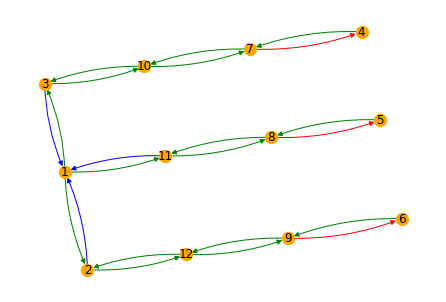

In [112]:
G = draw_clusters("blenheim_map.yaml", connections_clusters)
plt.savefig("clusters_connections_blenheim.svg")

## 2b) Blenheim Random

In [113]:
#separate by congestion level
congestion_1 = df_blenheim_random[ df_blenheim_random["n_robots"] == 1 ]
congestion_2 = df_blenheim_random[ df_blenheim_random["n_robots"] == 2 ]
congestion_3 = df_blenheim_random[ df_blenheim_random["n_robots"] == 3 ]
congestion_4 = df_blenheim_random[ df_blenheim_random["n_robots"] == 4 ]
congestion_5 = df_blenheim_random[ df_blenheim_random["n_robots"] == 5 ]
print(len(congestion_1),len(congestion_2),len(congestion_3),len(congestion_4),len(congestion_5))

6712 744 21 0 0


### 2bi) n_robots = 1
- Blenheim random
- 1 cluster

In [51]:
# n_robots = 1
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_1)

Time taken: 1.6700818538665771 secs


Optimum no. of clusters: 2
Max silhouette coeff: 0.5570355494102477


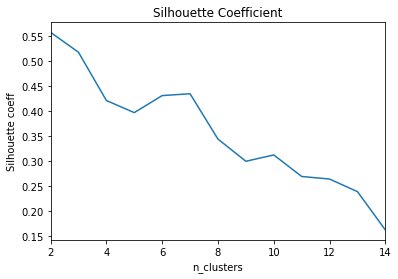

In [52]:
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 15, method = "ss")

### 2bii) n_robots = 2
- Blenheim random
- 1 cluster

In [118]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_2)

Time taken: 0.5067031383514404 secs


Optimum no. of clusters: 2
Max silhouette coeff: 0.6063604994138009


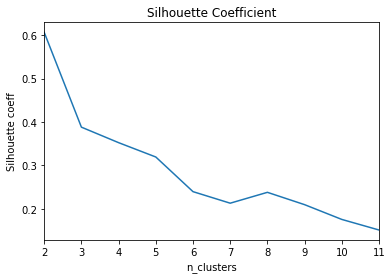

In [128]:
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 12, method = "ss")

In [131]:
clustering = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
2 clusters


no. of edges: 22
no. of colors: 22


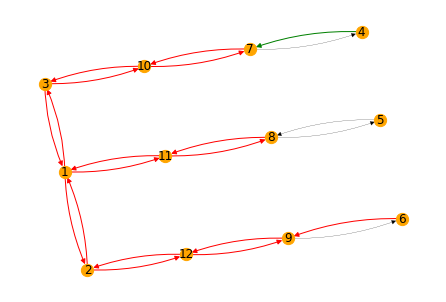

In [132]:
G = draw_clusters("blenheim_map.yaml", ks_clusters)
plt.savefig("clusters_ks_blenheim_random_2robots.svg")

### 2biii) n_robots = 3
- Blenheim random
- 1 cluster

In [137]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_3)

Time taken: 0.14212608337402344 secs


Optimum no. of clusters: 2
Min CH index: 1.2706713780918728


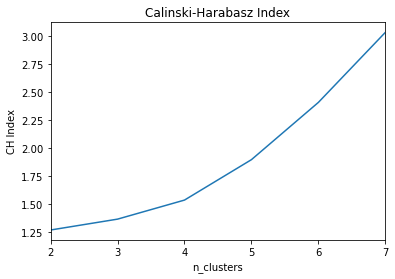

In [140]:
#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 8, method = "ch")

In [144]:
clustering = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[0 0 0 0 0 0 0 0 0 1]
7 clusters


no. of edges: 22
no. of colors: 22


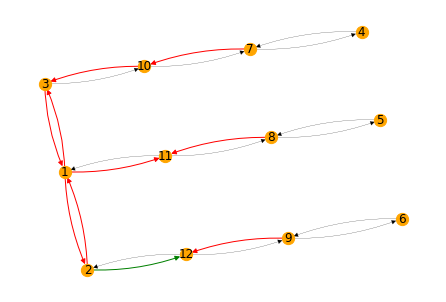

In [145]:
G = draw_clusters("blenheim_map.yaml", ks_clusters)
plt.savefig("clusters_ks_blenheim_random_3robots.svg")

## 2c) Blenheim Targeted

In [183]:
#separate by congestion level
congestion_1 = df_blenheim_targeted[ df_blenheim_targeted["n_robots"] == 1 ]
congestion_2 = df_blenheim_targeted[ df_blenheim_targeted["n_robots"] == 2 ]
congestion_3 = df_blenheim_targeted[ df_blenheim_targeted["n_robots"] == 3 ]
congestion_4 = df_blenheim_targeted[ df_blenheim_targeted["n_robots"] == 4 ]
congestion_5 = df_blenheim_targeted[ df_blenheim_targeted["n_robots"] == 5 ]
print(len(congestion_1),len(congestion_2),len(congestion_3),len(congestion_4),len(congestion_5))

8567 1019 53 0 0


In [147]:
congestion_1.head()

,origin,target,edge_id,operation_time,n_robots
0,WayPoint4,WayPoint7,WayPoint4_WayPoint7,11.574,1
1,WayPoint7,WayPoint10,WayPoint7_WayPoint10,12.874,1
2,WayPoint10,WayPoint3,WayPoint10_WayPoint3,13.195,1
4,WayPoint1,WayPoint3,WayPoint1_WayPoint3,12.965,1
5,WayPoint3,WayPoint10,WayPoint3_WayPoint10,12.116,1


### 2ci) n_robots = 1
- Blenheim targeted
- 1 cluster

In [65]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_1)

Time taken: 1.8892631530761719 secs


Optimum no. of clusters: 2
Max silhouette coeff: 0.585352777427854


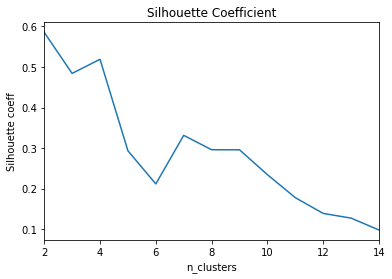

In [66]:
#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 15, method = "ss")

### 2cii) n_robots = 2
- Blenheim targeted
- 1 cluster

In [151]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_2)

Time taken: 0.3839755058288574 secs


Optimum no. of clusters: 2
Min CH index: 6.510956415077238


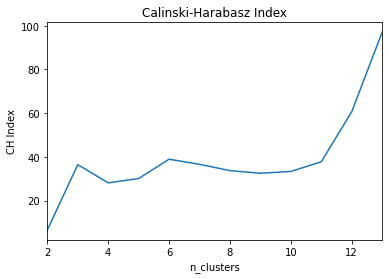

In [152]:
#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 14, method = "ch")

In [148]:
clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[0 0 0 0 0 0 2 0 0 1]
7 clusters


no. of edges: 22
no. of colors: 22


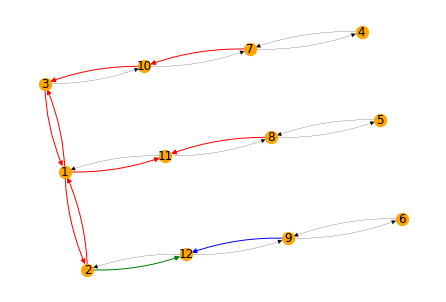

In [149]:
G = draw_clusters("blenheim_map.yaml", ks_clusters)
plt.savefig("clusters_ks_blenheim_targeted_2robots.svg")

### 2ciii) n_robots = 3
- Blenheim targeted
- 1 cluster

In [184]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_3)

Time taken: 0.10272526741027832 secs


Optimum no. of clusters: 2
Min CH index: 2.569257720483445


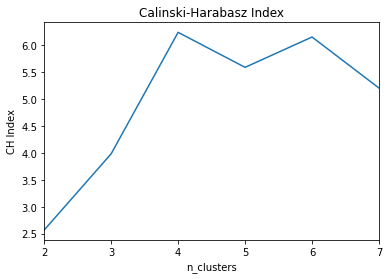

In [194]:
#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 8, method = "ch")

In [191]:
clustering = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[1 1 0 1 1 2 0 3]
4 clusters


no. of edges: 22
no. of colors: 22


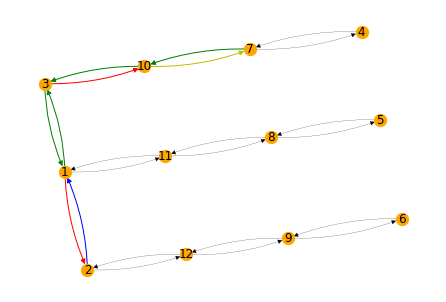

In [192]:
G = draw_clusters("blenheim_map.yaml", ks_clusters)
plt.savefig("clusters_ks_blenheim_targeted_3robots.svg")

## 2d) Blenheim combined

In [157]:
#separate by congestion level
random1 = df_blenheim_random[ df_blenheim_random["n_robots"] == 1 ]
random2 = df_blenheim_random[ df_blenheim_random["n_robots"] == 2 ]
random3 = df_blenheim_random[ df_blenheim_random["n_robots"] == 3 ]
random4 = df_blenheim_random[ df_blenheim_random["n_robots"] == 4 ]
random5 = df_blenheim_random[ df_blenheim_random["n_robots"] == 5 ]
print(len(random1),len(random2),len(random3),len(random4),len(random5))

6712 744 21 0 0


In [158]:
#separate by congestion level
targeted1 = df_blenheim_targeted[ df_blenheim_targeted["n_robots"] == 1 ]
targeted2 = df_blenheim_targeted[ df_blenheim_targeted["n_robots"] == 2 ]
targeted3 = df_blenheim_targeted[ df_blenheim_targeted["n_robots"] == 3 ]
targeted4 = df_blenheim_targeted[ df_blenheim_targeted["n_robots"] == 4 ]
targeted5 = df_blenheim_targeted[ df_blenheim_targeted["n_robots"] == 5 ]
print(len(targeted1),len(targeted2),len(targeted3),len(targeted4),len(targeted5))

8567 1019 53 0 0


In [159]:
congestion_1 = pd.concat([random1,targeted1]).reset_index()
congestion_2 = pd.concat([random2,targeted2]).reset_index()
congestion_3 = pd.concat([random3,targeted3]).reset_index()
congestion_4 = pd.concat([random4,targeted4]).reset_index()
congestion_5 = pd.concat([random5,targeted5]).reset_index()
print(len(congestion_1),len(congestion_2),len(congestion_3),len(congestion_4),len(congestion_5))

15279 1763 74 0 0


### 2di) n_robots = 1
- Blenheim combined
- 1 cluster

In [160]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_1)

Time taken: 3.243873357772827 secs


Optimum no. of clusters: 2
Max silhouette coeff: 0.5701878159754729


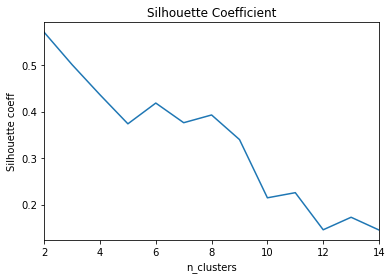

In [161]:
#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 15, method = "ss")

### 2dii) n_robots = 2
- Blenheim combined
- 1 cluster

In [162]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_2)

Time taken: 0.6747016906738281 secs


Optimum no. of clusters: 2
Max silhouette coeff: 0.6145284454734229


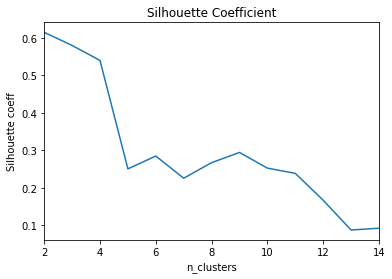

In [163]:
#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 15, method = "ss")

### 2diii) n_robots = 3
- Blenheim combined
- 1 cluster

In [164]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_3)

Time taken: 0.20348882675170898 secs


Optimum no. of clusters: 2
Max silhouette coeff: 0.28654285099403204


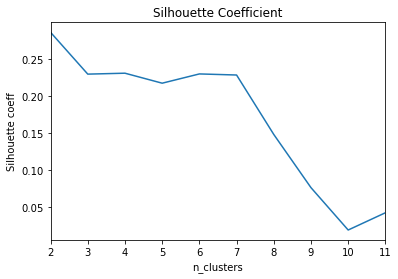

In [166]:
#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 12, method = "ss")

In [100]:
clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[0 0 0 0 0 0 0 1 0 0 0 2]
3 clusters


no. of edges: 22
no. of colors: 22


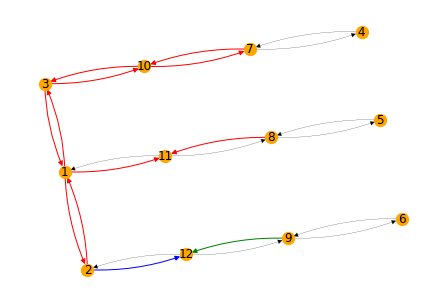

In [101]:
G = draw_clusters("blenheim_map.yaml",ks_clusters)
plt.savefig("clusters_ks_blenheim_combined_3robots.svg")

In [102]:
ks_df = pd.DataFrame(index = ks_edges, columns = ks_edges)
for i in range(len(ks_edges)):
    ks_df[ks_edges[i]] = ks_matrix[i]
ks_df.head()

,WayPoint3_WayPoint1,WayPoint10_WayPoint3,WayPoint1_WayPoint3,WayPoint2_WayPoint1,WayPoint3_WayPoint10,WayPoint1_WayPoint2,WayPoint7_WayPoint10,WayPoint9_WayPoint12,WayPoint8_WayPoint11,WayPoint1_WayPoint11,WayPoint10_WayPoint7,WayPoint2_WayPoint12
WayPoint3_WayPoint1,0.000000,0.514286,0.178571,0.321429,0.321429,0.321429,0.457143,0.928571,0.607143,0.714286,0.607143,0.857143
WayPoint10_WayPoint3,0.514286,0.000000,0.414286,0.657143,0.633333,0.466667,0.300000,0.700000,0.800000,0.700000,0.800000,0.500000
WayPoint1_WayPoint3,0.178571,0.414286,0.000000,0.428571,0.261905,0.285714,0.371429,0.857143,0.571429,0.714286,0.714286,0.714286
WayPoint2_WayPoint1,0.321429,0.657143,0.428571,0.000000,0.380952,0.428571,0.514286,0.857143,0.714286,0.857143,0.571429,0.857143
WayPoint3_WayPoint10,0.321429,0.633333,0.261905,0.380952,0.000000,0.333333,0.466667,1.000000,0.666667,0.833333,0.666667,0.833333


In [103]:
ks_df.to_excel("check.xlsx")
print("done")

done


# 3) Generalise Between Edges
- generalise between similar edges
- merge datasets for similar edges

In [19]:
# merge uncongested datasets for walmart map
random = df_walmart_random[ df_walmart_random["n_robots"] == 1 ]
targeted = df_walmart_targeted[ df_walmart_targeted["n_robots"] == 1 ]
df_walmart = pd.concat([random,targeted]).reset_index()
df_walmart = df_walmart[["origin","target","edge_id","operation_time"]]
df_walmart.head()

,origin,target,edge_id,operation_time
0,WayPoint110,WayPoint68,WayPoint110_WayPoint68,4.898
1,WayPoint68,WayPoint61,WayPoint68_WayPoint61,10.916
2,WayPoint61,WayPoint54,WayPoint61_WayPoint54,9.276
3,WayPoint54,WayPoint47,WayPoint54_WayPoint47,10.398
4,WayPoint47,WayPoint48,WayPoint47_WayPoint48,10.212


## 3a) Check similarity

In [6]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(df_walmart)


Time taken: 132.63484907150269 secs


Optimum no. of clusters: 6
Max silhouette coeff: 0.6543021412638623


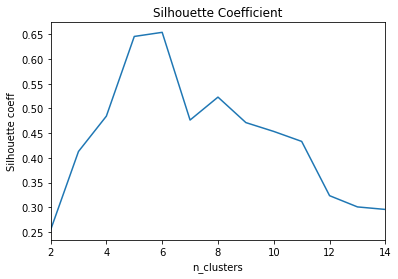

In [7]:
#optimum no. of clusters
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 15, method = "ss")

In [8]:
clustering = AgglomerativeClustering(n_clusters=6, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[1 0 5 5 1 1 1 5 1 0 0 5 0 0 1 5 5 1 5 0 0 4 0 1 5 1 1 1 4 1 4 4 1 1 5 5 1
 5 1 4 4 0 1 5 1 4 1 4 0 4 2 1 1 2 1 1 0 3 4 1 3 0 1 0 3 2 0 2 3 0 2 3 1 0
 0 0 1 1 0 0 1 0 0 0 1 2 0 0 1 0 2 1 0 0 2 0 0 0 4 2 0 0 0 0 0 0 1 0 2 0 0
 0 0 0 0 2 0 0 0 1 2 2 0 4 0 2 0 1 2 1 2 2 0 0 0 0 0 0 2 0 2 0 2 0 0 2 0 0
 0 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
6 clusters


no. of edges: 256
CLuster 0 has colour code: r
CLuster 1 has colour code: g
CLuster 2 has colour code: b
CLuster 3 has colour code: y
CLuster 4 has colour code: m
CLuster 5 has colour code: orange
Edges without enough data are black


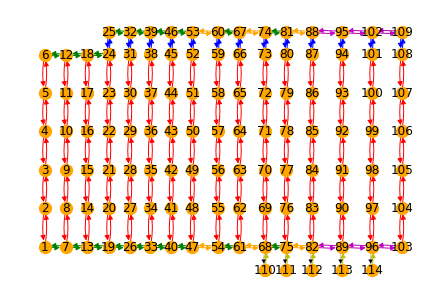

In [9]:
G = draw_clusters("walmart_map.yaml",ks_clusters)
plt.savefig("clusters_ks_walmart_combined.svg")

## 3b) Fit 2 arbitrary edges that are similar

In [10]:
#separate by cluster
print(len(ks_clusters))
ks_clusters.head()
   

251


,edge_id,cluster_id
0,WayPoint75_WayPoint68,1
1,WayPoint70_WayPoint71,0
2,WayPoint82_WayPoint75,5
3,WayPoint68_WayPoint61,5
4,WayPoint61_WayPoint54,1


In [11]:
# Select data of interest
wp1 = "WayPoint82"
wp2 = "WayPoint75"
edge1 = wp1 + "_" + wp2
subset1 = select_data_edge(df_walmart, edge1)
#independent variable to plot over
t_op1 = subset1["operation_time"]

wp1 = "WayPoint68"
wp2 = "WayPoint61"
edge2 = wp1 + "_" + wp2
subset2 = select_data_edge(df_walmart, edge2)
#independent variable to plot over
t_op2 = subset2["operation_time"]

print("done")

done


MAP mean: 0.28     MAP var: 0.36000000000000004
Time for calculation: 0.32711291313171387 secs


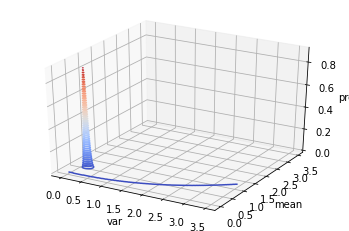

In [12]:
#fit model

#use offset and take log of data
#context = get_context("walmart_map.yaml")
#length = context.loc[context["edge_id"] == edge]["edge_length"]
#offset= np.min([float(length / (0.55 * 1.1) ), np.min(t_op) - 0.01])
offset1= np.min(t_op1) - 0.01
t_log = np.log(t_op1 - offset1)

#n_terms = 1 if you want just the initial estimates
n_terms = len(t_log)    
t_obs = t_log[0:n_terms]

#set parameters
mu_0 = 1
beta = 0.1
a = 1
b = 1

#Bayesian MAP estimate of mean & variance of Gaussian distribution
tic = time.time()
mean_test1, var_test1, posterior1, mean_map1, var_map1 = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b)
toc = time.time()
print("MAP mean:", mean_map1, "    MAP var:", var_map1)
print("Time for calculation:", toc-tic, "secs")

MAP mean: 0.08     MAP var: 1.1300000000000001
Time for calculation: 0.19812655448913574 secs


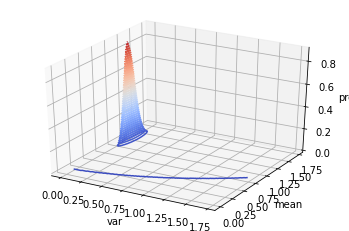

In [15]:
#fit model

#use offset and take log of data
#context = get_context("walmart_map.yaml")
#length = context.loc[context["edge_id"] == edge]["edge_length"]
#offset= np.min([float(length / (0.55 * 1.1) ), np.min(t_op) - 0.01])
offset2= np.min(t_op2) - 0.01
t_log = np.log(t_op2 - offset2)

#n_terms = 1 if you want just the initial estimates
n_terms = len(t_log)    
t_obs = t_log[0:n_terms]

#set parameters
mu_0 = 1
beta = 0.1
a = 1
b = 1

#Bayesian MAP estimate of mean & variance of Gaussian distribution
tic = time.time()
mean_test2, var_test2, posterior2, mean_map2, var_map2 = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b)
toc = time.time()
print("MAP mean:", mean_map2, "    MAP var:", var_map2)
print("Time for calculation:", toc-tic, "secs")

Text(0.5, 1.0, 'WayPoint82_WayPoint75')

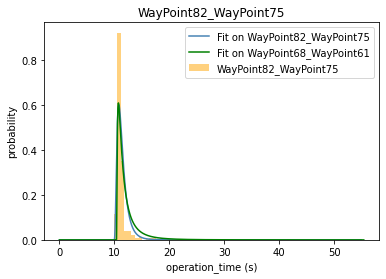

In [16]:
#Plot against actual data

precision = 2
t_start= 10**(-precision)
t_stop = ( (np.max(t_op1)) //5)*5 + 5    #round up to nearest 5 secs
t_step = 10**(-precision)
t_test = np.arange(t_start,t_stop,t_step)

#Duration distribution using MAP parameters from Bayesian method
p_bayes1 = Lognormal(t_test,mean_map1,var_map1)
p_bayes2 = Lognormal(t_test,mean_map2,var_map2)

#account for offset
t_offset1 = np.arange(t_stop, t_stop+offset1, t_step)
p_offset1 = np.zeros(len(t_offset1))
p_bayes1 = np.array([*p_offset1, *p_bayes1])
t_test1 = np.array([*t_test, *t_offset1])

t_offset2 = np.arange(t_stop, t_stop+offset2, t_step)
p_offset2 = np.zeros(len(t_offset2))
p_bayes2 = np.array([*p_offset2, *p_bayes2])
t_test2 = np.array([*t_test, *t_offset2])

#plot
plt.plot(t_test1,p_bayes1, color = "steelblue", alpha = 1)
plt.plot(t_test2,p_bayes2, color = "green", alpha = 1)
plt.hist(t_op1, density = True, bins = 50, color = "orange", alpha = 0.5)
#plt.hist(t_op2, density = True, bins = 50, color = "red", alpha = 0.5)

plt.legend(["Fit on " + edge1,"Fit on " + edge2, edge1, edge2])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(edge1)

In [17]:
#crps test 
#fitted on edge 1 & tested against data from edge 1
cdf_bayes1 = integrate_pdf(p_bayes1, spacing = t_test1[1] - t_test1[0])
crps1 = error_crps(np.array(t_op1),cdf_bayes1,t_test1, method = "rectangle")
#ks1 = error_ks(t_test1, p_bayes1, t_op, plot_graph = True)
ks1 = sp.stats.kstest(t_op1,cdf_bayes1)
print("CRPS:", crps1["crps"].mean())
print("KS:", ks1)

CRPS: 0.519145117126143
KS: KstestResult(statistic=1.0, pvalue=0.0)


In [18]:
#crps test 
#fitted on edge 2 & tested against data from edge 1
cdf_bayes2 = integrate_pdf(p_bayes2, spacing = t_test2[1] - t_test2[0])
crps2 = error_crps(np.array(t_op1),cdf_bayes2,t_test2, method = "rectangle")
print(crps2["crps"].mean())

0.6409699448317289


In [19]:
#crps test 
#fitted on edge 1 & tested against data from edge 2
cdf_bayes1 = integrate_pdf(p_bayes1, spacing = t_test1[1] - t_test1[0])
crps1 = error_crps(np.array(t_op2),cdf_bayes1,t_test1, method = "rectangle")
print(crps1["crps"].mean())

0.3652836338716737


In [20]:
#crps test 
#fitted on edge 2 & tested against data from edge 2
cdf_bayes2 = integrate_pdf(p_bayes2, spacing = t_test2[1] - t_test2[0])
crps2 = error_crps(np.array(t_op2),cdf_bayes2,t_test2, method = "rectangle")
print(crps2["crps"].mean())

0.5156487996305252


## 3c) All edges in a cluster

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug  3 19:52:31 2021

@author: pyliu
"""
import pandas as pd
import numpy as np
import math
import scipy as sp
from copy import copy
import time


from Lognormal import *
from Normal_Gamma_bayes import *
from integrate_pdf import *
from error_crps import *
from select_data_edge import *


def crps_between_edges(df, edge_list, metric = "median"):
    """
    Compares CRPS of a fitted distribution for one edge with observations from a second edge

    Parameters
    ----------
    df : pandas dataframe
        columns = ["origin", "target", "edge_id", "operation_time"]
    edge_list : STR, vector
        list of "edge_id" in a particular cluster
    metric : STR
        CRPS vector is as long as the number of observations of the second edge.
        We return either the "mean" or "variance" of these CRPS scores.
        The default is "median".

    Raises
    ------
    ValueError
        The metric is invalid. metric can only be one of "mean" or "variance"

    Returns
    -------
    crps_df : pandas dataframe
        column & row headers are the edge_ids
        The dataframe contains the crps scores between the different edges

    """
    valid_metrics = ["mean", "median"]
    tic = time.time()
    if metric not in valid_metrics:
        raise ValueError("Invalid metric - check help(crps_between_edges) for valid metrics")
    # 1) Initialise pandas df
    #turn off warnings
    pd.options.mode.chained_assignment = None  # default='warn'
    crps_df = pd.DataFrame(index = edge_list, columns = edge_list)
    
    # 2) crps between edges
    for i in range(len(edge_list)-1):
        
        #2a) fit parameters of edge 1
        edge1 = edge_list[i]
        subset1 = select_data_edge(df, edge1)
        #independent variable to plot over
        t_op1 = subset1["operation_time"]
        
        offset1= np.min(t_op1) - 0.01
        t_log = np.log(t_op1 - offset1)
        #n_terms = 1 if you want just the initial estimates
        n_terms = len(t_log)    
        t_obs = t_log[0:n_terms]
        
        #set parameters
        mu_0 = 1
        beta = 0.1
        a = 1
        b = 1
        
        #Bayesian MAP estimate of mean & variance of Gaussian distribution
        mean_test1, var_test1, posterior1, mean_map1, var_map1 = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b, plot_graph = False)
        
        # 2b) create models of edge 1
        precision = 2
        t_start= 10**(-precision)
        t_stop = ( (np.max(t_op1)) //5)*5 + 5    #round up to nearest 5 secs
        t_step = 10**(-precision)
        t_test = np.arange(t_start,t_stop,t_step)
        
        #Duration distribution using MAP parameters from Bayesian method
        p_bayes1 = Lognormal(t_test,mean_map1,var_map1)
        
        #account for offset
        t_offset1 = np.arange(t_stop, t_stop+offset1, t_step)
        p_offset1 = np.zeros(len(t_offset1))
        p_bayes1 = np.array([*p_offset1, *p_bayes1])
        t_test1 = np.array([*t_test, *t_offset1])
        
        
        for j in range(i+1,len(edge_list)):
            #2c) fit parameters of edge 2
            edge2 = edge_list[j]
            subset2 = select_data_edge(df, edge2)
            #independent variable to plot over
            t_op2 = subset2["operation_time"]
            
            offset2= np.min(t_op2) - 0.01
            t_log = np.log(t_op2 - offset2)
            
            #n_terms = 1 if you want just the initial estimates
            n_terms = len(t_log)    
            t_obs = t_log[0:n_terms]
            
            #set parameters
            mu_0 = 1
            beta = 0.1
            a = 1
            b = 1
            
            #Bayesian MAP estimate of mean & variance of Gaussian distribution
            mean_test2, var_test2, posterior2, mean_map2, var_map2 = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b, plot_graph = False)

            # 2d) create models of edge 2
            #Duration distribution using MAP parameters from Bayesian method
            p_bayes2 = Lognormal(t_test,mean_map2,var_map2)
        
            #account for offset
            t_offset2 = np.arange(t_stop, t_stop+offset2, t_step)
            p_offset2 = np.zeros(len(t_offset2))
            p_bayes2 = np.array([*p_offset2, *p_bayes2])
            t_test2 = np.array([*t_test, *t_offset2])
    
            # 3) calculate crps & store result
            
            #fitted on edge 1 & tested against data from edge 1
            cdf_bayes1 = integrate_pdf(p_bayes1, spacing = t_test1[1] - t_test1[0])
            crps1 = error_crps(np.array(t_op1),cdf_bayes1,t_test1, method = "rectangle")
            if metric == "mean":
                crps_df.loc[edge1,edge1] = crps1["crps"].mean()
            elif metric == "median":
                crps_df.loc[edge1,edge1] = crps1["crps"].median()
            else:
                raise ValueError("Invalid metric - check help(crps_between_edges) for valid metrics")
    
            #fitted on edge 2 & tested against data from edge 1
            cdf_bayes2 = integrate_pdf(p_bayes2, spacing = t_test2[1] - t_test2[0])
            crps2 = error_crps(np.array(t_op1),cdf_bayes2,t_test2, method = "rectangle")
            if metric == "mean":
                crps_df.loc[edge2,edge1] = crps2["crps"].mean()
            elif metric == "median":
                crps_df.loc[edge2,edge1] = crps2["crps"].median()
            else:
                raise ValueError("Invalid metric - check help(crps_between_edges) for valid metrics")
    
            #fitted on edge 1 & tested against data from edge 2
            cdf_bayes1 = integrate_pdf(p_bayes1, spacing = t_test1[1] - t_test1[0])
            crps1 = error_crps(np.array(t_op2),cdf_bayes1,t_test1, method = "rectangle")
            if metric == "mean":
                crps_df.loc[edge1,edge2] = crps1["crps"].mean()
            elif metric == "median":
                crps_df.loc[edge1,edge2] = crps1["crps"].median()
            else:
                raise ValueError("Invalid metric - check help(crps_between_edges) for valid metrics")
                
            #fitted on edge 2 & tested against data from edge 2
            cdf_bayes2 = integrate_pdf(p_bayes2, spacing = t_test2[1] - t_test2[0])
            crps2 = error_crps(np.array(t_op2),cdf_bayes2,t_test2, method = "rectangle")
            if metric == "mean":
                crps_df.loc[edge2,edge2] = crps2["crps"].mean()
            elif metric == "median":
                crps_df.loc[edge2,edge2] = crps2["crps"].median()
            else:
                raise ValueError("Invalid metric - check help(crps_between_edges) for valid metrics")
                
    toc = time.time()
    print("Time taken:", toc-tic, "secs")
    return crps_df
            

In [10]:
edge_list = np.array( ks_clusters[ ks_clusters["cluster_id"] == 0]["edge_id"] )
print(len(edge_list))
if len(edge_list) > 5:
    crps_df = crps_between_edges(df_walmart,edge_list[0:60], metric = "median")
else:
    crps_df = crps_between_edges(df_walmart,edge_list, metric = "median")
crps_df.head()

160
Time taken: 67.53232479095459 secs


,WayPoint70_WayPoint71,WayPoint68_WayPoint69,WayPoint71_WayPoint70,WayPoint69_WayPoint70,WayPoint71_WayPoint72,WayPoint72_WayPoint71,WayPoint69_WayPoint68,WayPoint70_WayPoint69,WayPoint72_WayPoint73,WayPoint73_WayPoint72,...,WayPoint55_WayPoint54,WayPoint14_WayPoint15,WayPoint85_WayPoint86,WayPoint84_WayPoint85,WayPoint76_WayPoint75,WayPoint14_WayPoint13,WayPoint76_WayPoint77,WayPoint91_WayPoint90,WayPoint2_WayPoint3,WayPoint41_WayPoint42
WayPoint70_WayPoint71,0.568496,0.433524,0.626434,0.517592,0.562271,0.626434,0.489898,0.679841,0.613973,0.601867,...,0.415955,0.611191,0.498315,0.500092,0.433524,0.413732,0.522217,0.607876,0.483941,0.55444
WayPoint68_WayPoint69,0.331886,0.203296,0.413562,0.27982,0.338726,0.480379,0.331886,0.534909,0.374728,0.352772,...,0.187159,0.335675,0.235538,0.228853,0.266305,0.26195,0.240063,0.331886,0.21652,0.273409
WayPoint71_WayPoint70,0.628159,0.515074,0.68172,0.585564,0.628159,0.671403,0.548033,0.708964,0.671403,0.651543,...,0.498372,0.669066,0.573254,0.574849,0.498372,0.494359,0.594033,0.666341,0.560654,0.621525
WayPoint69_WayPoint70,0.307678,0.167333,0.381763,0.232466,0.307678,0.558043,0.393285,0.598108,0.334922,0.375881,...,0.173237,0.268754,0.149537,0.164603,0.264161,0.208413,0.201044,0.264161,0.120023,0.199658
WayPoint71_WayPoint72,0.288787,0.168162,0.373172,0.22822,0.288787,0.580841,0.423063,0.6219,0.325324,0.382838,...,0.19424,0.249567,0.149225,0.147118,0.260334,0.22246,0.181742,0.244922,0.107719,0.192995


In [11]:
crps_df.to_excel("crps_median_cluster0.xlsx")
print("done")

done


In [12]:
edge_list = np.array( ks_clusters[ ks_clusters["cluster_id"] == 1]["edge_id"] )
print(len(edge_list))
if len(edge_list) > 5:
    crps_df = crps_between_edges(df_walmart,edge_list[0:30], metric = "median")
else:
    crps_df = crps_between_edges(df_walmart,edge_list, metric = "median")
crps_df.head()

36
Time taken: 46.803438663482666 secs


,WayPoint75_WayPoint68,WayPoint61_WayPoint54,WayPoint53_WayPoint46,WayPoint60_WayPoint67,WayPoint46_WayPoint53,WayPoint67_WayPoint60,WayPoint68_WayPoint75,WayPoint47_WayPoint40,WayPoint46_WayPoint39,WayPoint39_WayPoint46,...,WayPoint26_WayPoint33,WayPoint19_WayPoint26,WayPoint19_WayPoint13,WayPoint25_WayPoint32,WayPoint32_WayPoint25,WayPoint13_WayPoint19,WayPoint13_WayPoint7,WayPoint24_WayPoint18,WayPoint18_WayPoint24,WayPoint7_WayPoint13
WayPoint75_WayPoint68,0.27672,0.288491,0.39549,0.310564,0.408929,0.301364,0.266035,0.341155,0.524639,0.358142,...,0.559522,0.382543,0.266035,0.288491,0.352417,0.262713,0.330457,0.241497,0.262713,0.341155
WayPoint61_WayPoint54,0.318516,0.331264,0.427523,0.354111,0.444003,0.344619,0.307677,0.385454,0.55406,0.402755,...,0.606212,0.427523,0.307677,0.331264,0.3911,0.300722,0.374525,0.270243,0.297411,0.385454
WayPoint53_WayPoint46,0.270382,0.272002,0.34643,0.287528,0.367587,0.28098,0.272002,0.305907,0.457076,0.318339,...,0.483156,0.336583,0.257008,0.272002,0.318604,0.257008,0.298208,0.24914,0.254884,0.309498
WayPoint60_WayPoint67,0.14042,0.13695,0.267998,0.167042,0.286357,0.162747,0.148542,0.181047,0.355941,0.220683,...,0.382259,0.214134,0.127785,0.134013,0.190827,0.135151,0.162644,0.138981,0.127785,0.208588
WayPoint46_WayPoint53,0.23195,0.229854,0.299563,0.252839,0.328049,0.241253,0.234158,0.255978,0.387364,0.277639,...,0.407593,0.281325,0.224238,0.229854,0.267922,0.225999,0.246919,0.22664,0.224238,0.274504


In [13]:
crps_df.to_excel("crps_median_cluster1.xlsx")
print("done")

done


In [14]:
edge_list = np.array( ks_clusters[ ks_clusters["cluster_id"] == 2]["edge_id"] )
print(len(edge_list))
if len(edge_list) > 5:
    crps_df = crps_between_edges(df_walmart,edge_list[0:13], metric = "median")
else:
    crps_df = crps_between_edges(df_walmart,edge_list, metric = "median")
crps_df.head()

26
Time taken: 2.746509075164795 secs


,WayPoint108_WayPoint109,WayPoint109_WayPoint108,WayPoint52_WayPoint53,WayPoint24_WayPoint25,WayPoint25_WayPoint24,WayPoint94_WayPoint95,WayPoint95_WayPoint94,WayPoint101_WayPoint102,WayPoint53_WayPoint52,WayPoint38_WayPoint39,WayPoint102_WayPoint101,WayPoint80_WayPoint81,WayPoint59_WayPoint60
WayPoint108_WayPoint109,0.533296,0.694321,0.568183,0.478996,0.443325,0.479044,0.446917,0.483434,0.474655,0.479044,0.436409,0.462205,0.544501
WayPoint109_WayPoint108,0.71349,0.775883,0.781985,0.716886,0.680172,0.716886,0.684813,0.724751,0.719481,0.724791,0.671117,0.689531,0.800806
WayPoint52_WayPoint53,0.531898,0.615965,0.46437,0.397343,0.373023,0.405752,0.373023,0.405752,0.392561,0.395765,0.365976,0.383647,0.44557
WayPoint24_WayPoint25,0.521222,0.717696,0.57095,0.467771,0.42509,0.462629,0.429437,0.467771,0.462629,0.467821,0.416685,0.447808,0.543964
WayPoint25_WayPoint24,0.506836,0.709365,0.579611,0.462189,0.41321,0.4563,0.418209,0.462189,0.4563,0.462246,0.40354,0.439307,0.549059


In [15]:
crps_df.to_excel("crps_median_cluster2.xlsx")
print("done")

done


In [16]:
edge_list = np.array( ks_clusters[ ks_clusters["cluster_id"] == 3]["edge_id"] )
print(len(edge_list))
crps_df = crps_between_edges(df_walmart,edge_list[0:3], metric = "median")
crps_df.head()

5
Time taken: 0.1351931095123291 secs


,WayPoint110_WayPoint68,WayPoint112_WayPoint82,WayPoint111_WayPoint75
WayPoint110_WayPoint68,0.520762,0.489812,0.526335
WayPoint112_WayPoint82,0.575292,0.534277,0.582558
WayPoint111_WayPoint75,0.489716,0.458081,0.495417


In [17]:
crps_df.to_excel("crps_median_cluster3.xlsx")
print("done")

done


In [18]:
edge_list = np.array( ks_clusters[ ks_clusters["cluster_id"] == 4]["edge_id"] )
print(len(edge_list))
crps_df = crps_between_edges(df_walmart,edge_list[0:12])
crps_df.head()

12
Time taken: 9.224289655685425 secs


,WayPoint89_WayPoint82,WayPoint95_WayPoint102,WayPoint102_WayPoint109,WayPoint102_WayPoint95,WayPoint109_WayPoint102,WayPoint82_WayPoint89,WayPoint96_WayPoint89,WayPoint95_WayPoint88,WayPoint88_WayPoint95,WayPoint89_WayPoint96,WayPoint96_WayPoint103,WayPoint103_WayPoint96
WayPoint89_WayPoint82,0.28873,0.313812,0.424532,0.290675,0.356585,0.353819,0.264696,0.325518,0.353819,0.266883,0.26779,0.241684
WayPoint95_WayPoint102,0.141972,0.230579,0.49972,0.170931,0.334971,0.276955,0.210656,0.145147,0.170931,0.110549,0.0721921,0.105926
WayPoint102_WayPoint109,0.888894,0.916008,0.927412,0.877592,0.945066,0.927412,0.775119,0.933238,0.981951,0.885557,0.915932,0.851863
WayPoint102_WayPoint95,0.236768,0.286165,0.471027,0.242242,0.361118,0.356512,0.18984,0.307441,0.356512,0.193052,0.196263,0.138668
WayPoint109_WayPoint102,0.852715,0.862125,0.883006,0.842898,0.897765,0.872681,0.766142,0.889579,0.915565,0.834253,0.852912,0.799953


In [19]:
crps_df.to_excel("crps_median_cluster4.xlsx")
print("done")

done


In [20]:
edge_list = np.array( ks_clusters[ ks_clusters["cluster_id"] == 5]["edge_id"] )
print(len(edge_list))
crps_df = crps_between_edges(df_walmart,edge_list[0:12], metric = "median")
crps_df.head()

12
Time taken: 14.41572880744934 secs


,WayPoint82_WayPoint75,WayPoint68_WayPoint61,WayPoint53_WayPoint60,WayPoint54_WayPoint47,WayPoint74_WayPoint67,WayPoint60_WayPoint53,WayPoint67_WayPoint74,WayPoint75_WayPoint82,WayPoint88_WayPoint81,WayPoint61_WayPoint68,WayPoint47_WayPoint54,WayPoint81_WayPoint88
WayPoint82_WayPoint75,0.244051,0.244051,0.297771,0.285878,0.329404,0.365297,0.335093,0.247465,0.247465,0.250998,0.297771,0.27908
WayPoint68_WayPoint61,0.412202,0.435154,0.483662,0.501941,0.473594,0.538282,0.541751,0.440407,0.445129,0.44423,0.501941,0.472069
WayPoint53_WayPoint60,0.213422,0.210873,0.258254,0.234778,0.286011,0.309817,0.276175,0.219076,0.216096,0.214423,0.258063,0.229913
WayPoint54_WayPoint47,0.22863,0.227102,0.276803,0.263396,0.301762,0.348465,0.307146,0.230158,0.233339,0.233339,0.272204,0.255109
WayPoint74_WayPoint67,0.377593,0.392642,0.443918,0.440093,0.44485,0.498239,0.486703,0.398098,0.401851,0.398098,0.453427,0.432896


In [21]:
crps_df.to_excel("crps_median_cluster5.xlsx")
print("done")

done


In [232]:
mergefit_stats.head()

,edge_id,crps,ks,crps_orig,ks_orig
0,WayPoint70_WayPoint71,0.33414,"(0.30233724948341456, 6.592139298890802e-37)",0.573732,"(0.11739321679657144, 7.557783842382116e-06)"
1,WayPoint68_WayPoint69,0.170036,"(0.10690461320400524, 0.00033131954377412236)",0.201674,"(0.12296624214763652, 1.9954699865841356e-05)"
2,WayPoint71_WayPoint70,0.419139,"(0.33798796461762626, 5.253382981314509e-38)",0.693075,"(0.12348497953971732, 2.384397029858402e-05)"
3,WayPoint69_WayPoint70,0.265071,"(0.24709923730215555, 2.962662540936673e-19)",0.222645,"(0.3472119518188729, 4.2533064649626883e-38)"
4,WayPoint71_WayPoint72,0.343223,"(0.3453916197856777, 6.021292994092232e-37)",0.230494,"(0.3872919433726113, 1.0963245128014576e-46)"


## 3d) Generalising merged datasets

MAP mean: 0.11
MAP var: 0.54
Offset: 9.4
Time taken: 17.127511501312256 secs


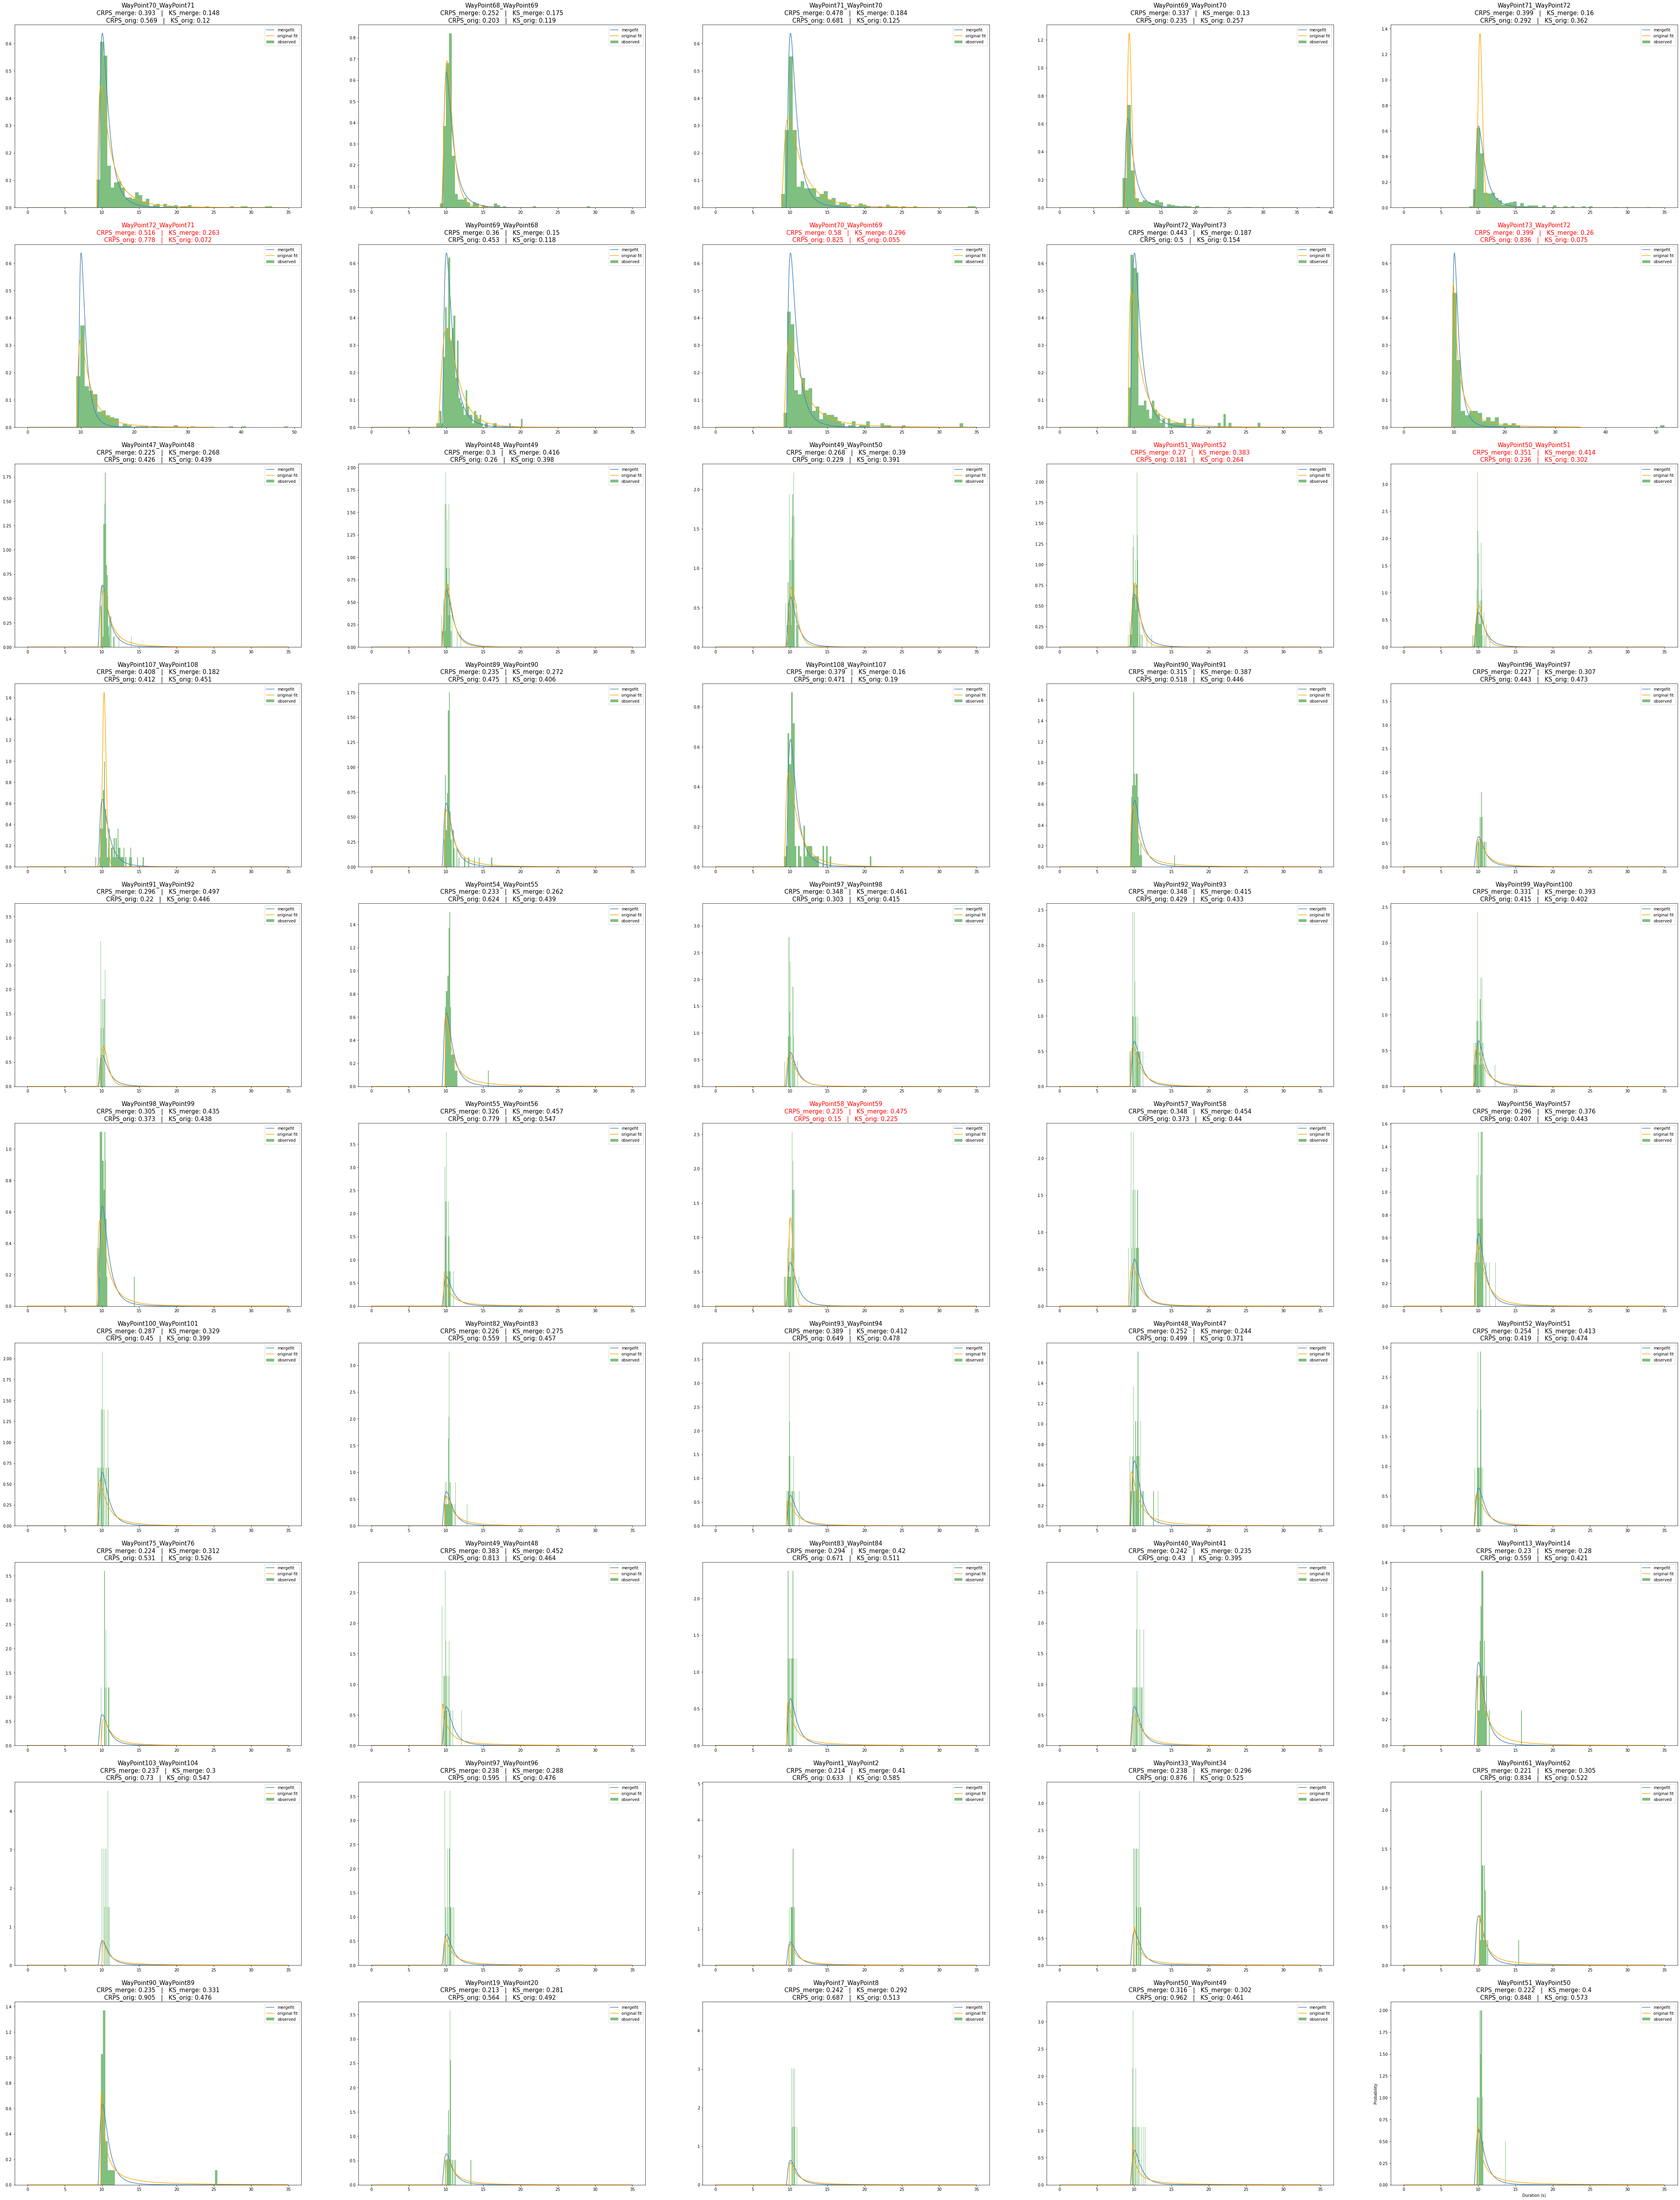

In [35]:
edge_list = np.array( ks_clusters[ ks_clusters["cluster_id"] == 0]["edge_id"] )
edge_list = edge_list[0:50]
mergefit_stats = mergefit_crps_ks(df_walmart, edge_list, n_samples = 5)

In [11]:
#save to excel
mergefit_stats.to_excel("mergefit_stats_20samples.xlsx")
mergefit_stats.head()

,edge_id,n_samples,crps,ks,crps_orig,ks_orig,crps_diff,ks_diff
0,WayPoint70_WayPoint71,459,0.361627,"(0.31989167059429235, 1.8498623176707857e-40)",0.570575,"(0.11028655348752825, 4.176405369840956e-05)",-0.208948,0.209605
1,WayPoint68_WayPoint69,387,0.160523,"(0.12714766391023832, 1.2447296435890303e-05)",0.202666,"(0.11348849260439475, 0.00014224925384300098)",-0.0421429,0.0136592
2,WayPoint71_WayPoint70,378,0.446778,"(0.3488801186940218, 1.8895249078625478e-39)",0.688065,"(0.11945212616529893, 6.57572689708787e-05)",-0.241287,0.229428
3,WayPoint69_WayPoint70,359,0.290191,"(0.26374985208709956, 2.6593627830280444e-21)",0.249902,"(0.26904841693571413, 3.669946940766298e-22)",0.0402891,-0.00529856
4,WayPoint71_WayPoint72,352,0.3786,"(0.36541703827181105, 3.0204608159143683e-40)",0.322429,"(0.38001996127573556, 1.318155725627328e-43)",0.0561716,-0.0146029


In [39]:
edge_list = np.array( ks_clusters[ ks_clusters["cluster_id"] == 0]["edge_id"] )
samples = []
mean = []
var = []
offset = []

for i in range(1,10):
    n_samples = i
    samples.append(n_samples)
    m,v,o =  mergefit(df_walmart, edge_list, n_samples)
    mean.append(m)
    var.append(v)
    offset.append(o)
    print(n_samples,"datapoints | params:", m,v,o)

for i in range(2,21):
    n_samples = i*5
    samples.append(n_samples)
    m,v,o =  mergefit(df_walmart, edge_list, n_samples)
    mean.append(m)
    var.append(v)
    offset.append(o)
    print(n_samples,"datapoints | params:", m,v,o)

1 datapoints | params: 0.14 0.4 9.177
2 datapoints | params: 0.2 0.19 9.177
3 datapoints | params: 0.17 0.22 9.177
4 datapoints | params: 0.17 0.2 9.177
5 datapoints | params: 0.16 0.22 9.177
6 datapoints | params: 0.16 0.23 9.177
7 datapoints | params: 0.21000000000000002 0.13 9.09
8 datapoints | params: 0.21000000000000002 0.13 9.09
9 datapoints | params: 0.2 0.12 9.09
10 datapoints | params: 0.26 0.08 9.09
15 datapoints | params: 0.28 0.060000000000000005 9.09
20 datapoints | params: 0.28 0.060000000000000005 9.09
25 datapoints | params: 0.28 0.060000000000000005 9.09
30 datapoints | params: 0.28 0.060000000000000005 9.09
35 datapoints | params: 0.28 0.060000000000000005 9.09
40 datapoints | params: 0.28 0.060000000000000005 9.09
45 datapoints | params: 0.49 0.02 8.668000000000001
50 datapoints | params: 0.49 0.02 8.668000000000001
55 datapoints | params: 0.49 0.02 8.668000000000001
60 datapoints | params: 0.49 0.02 8.668000000000001
65 datapoints | params: 0.49 0.02 8.6680000000000

In [1]:
#plt.plot(samples,mean,"steelblue")
plt.plot(samples,var,"orange")
#plt.plot(samples,offset,"lightgreen")
plt.title("params vs n_samples")
plt.xlabel("n_samples")
plt.ylabel("params")
#plt.legend(["mean", "var", "offset"])

NameError: name 'plt' is not defined

Text(0, 0.5, 'mean')

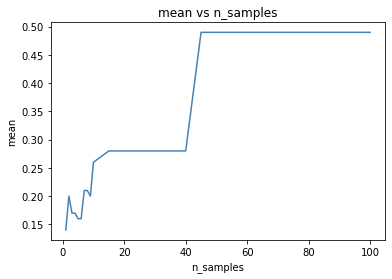

In [42]:
plt.plot(samples,mean,"steelblue")
plt.title("mean vs n_samples")
plt.xlabel("n_samples")
plt.ylabel("mean")

# 4) Generalise between dissimilar edges

## 4a) Mergefit parameters for each cluster

In [17]:
n_data = [160, 36, 26, 5, 12, 12]
parameters_df = pd.DataFrame(index = np.arange(len(n_data)), columns = ["cluster", "mean", "var", "offset", "edge_length"])
parameters_df["cluster"] = np.arange(len(n_data))
context = get_context("walmart_map.yaml")
for i in range(len(n_data)):
    edge_list = np.array( ks_clusters[ ks_clusters["cluster_id"] == i]["edge_id"] )
    edge_list = edge_list[0:n_data[i]]
    parameters_df["mean"][i], parameters_df["var"][i], parameters_df["offset"][i] = mergefit(df_walmart, edge_list, n_samples = 500//n_data[i])
    edges = ks_clusters[ks_clusters["cluster_id"] == i]["edge_id"]
    for edge in edges:
        parameters_df["edge_length"][i] = float ( context.loc[context['edge_id'] == edge]["edge_length"] )
        break
parameters_df.head(6)
    


Time taken: 1.2965314388275146 secs


,cluster,mean,var,offset,edge_length
0,0,0.17,0.22,9.177,5.50465
1,1,0.15,0.28,8.253,4.91539
2,2,0.19,0.08,5.043,3.21465
3,3,0.08,1.17,4.668,3.32
4,4,0.1,0.97,12.035,6.89378
5,5,0.12,0.61,10.098,5.90828


Text(0, 0.5, 'Mean')

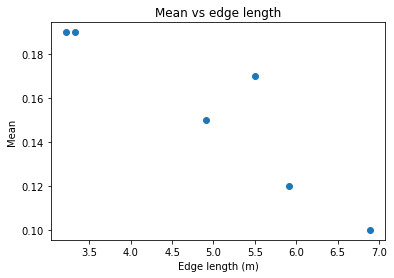

In [221]:
plt.scatter(parameters_df["edge_length"],parameters_df["mean"])
plt.title("Mean vs edge length")
plt.xlabel("Edge length (m)")
plt.ylabel("Mean")

Text(0, 0.5, 'Var')

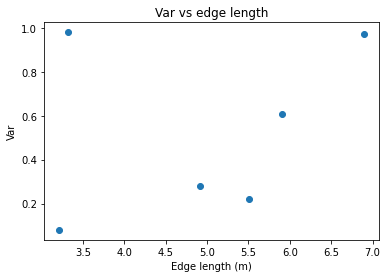

In [222]:
plt.scatter(parameters_df["edge_length"],parameters_df["var"])
plt.title("Var vs edge length")
plt.xlabel("Edge length (m)")
plt.ylabel("Var")

Text(0, 0.5, 'Offset')

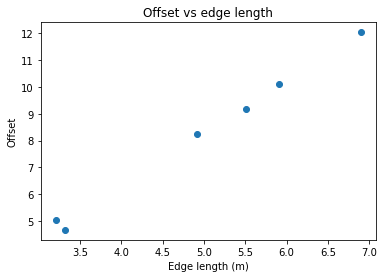

In [223]:
plt.scatter(parameters_df["edge_length"],parameters_df["offset"])
plt.title("Offset vs edge length")
plt.xlabel("Edge length (m)")
plt.ylabel("Offset")

## 4b) Linear regression for Offset vs Edge_length

In [234]:

def train_regression(nb, x_train, y_train):
    """
    Fits a polynomial model to data

    Parameters
    ----------
    nb : INT, scalar
        order of polynomial used for fitting
    x_train : FLOAT, vector
        independent variable for training
    y_train : FLOAT, vector
        dependent variable for training

    Returns
    -------
    w : FLOAT, vector
        contains coefficients of the fitted polynomial

    """

    #-1 means we do not care what the value is
    x = np.reshape(x_train,(-1,1))
      
    #w_0 + w1*x + w2*x^2 + ... w_nb*x^nb
    basis = np.arange(nb+1)
      
    #we want basis to be a row vector
    basis = np.reshape(basis,(1,-1))
      
    # A = [x^0, x^1, ... x^nb]
    A_train = x**basis
      
      
    # @ is matrix multiplication
    # w = (A^T A) ^(-1) * (A^T b)
    w = np.linalg.inv(A_train.T@A_train) @ (A_train.T @ y_train)
      
    return w

polynomial coeff: [-1.56801521  1.97206009]


Text(0.5, 1.0, 'Linear Regression: offset vs edge_length')

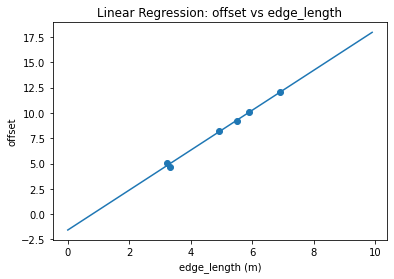

In [235]:
#What parameter are we fitting?
param = "offset"

# define nb = number of bases = order of polynomial
nb = 1

#train
w = train_regression(nb, list(parameters_df["edge_length"]),list(parameters_df[param]) )
print("polynomial coeff:",w)

#create test edge_lengths
length_test = np.arange(0,10,0.1)
x = np.reshape(length_test,(-1,1))

#predict
basis = np.arange(nb+1)
A_test = x**basis
y_predict = A_test@w

#plot
plt.plot(length_test, y_predict)
plt.scatter( list(parameters_df["edge_length"]),list(parameters_df[param]) )
plt.xlabel("edge_length (m)")
plt.ylabel("offset")
plt.title(f"Linear Regression: {param} vs edge_length")

## 4c) Linear Regression for Mean vs Edge_length

polynomial coeff: [ 0.26933552 -0.02339009]


Text(0.5, 1.0, 'Linear Regression: mean vs edge_length')

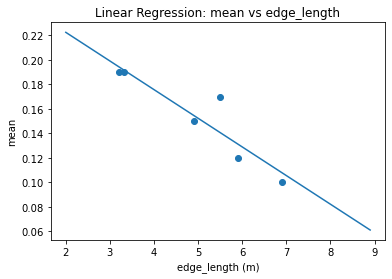

In [226]:
#What parameter are we fitting?
param = "mean"

# define nb = number of bases = order of polynomial
nb = 1

#train
w = train_regression(nb, list(parameters_df["edge_length"]),list(parameters_df[param]) )
print("polynomial coeff:",w)

#create test edge_lengths
length_test = np.arange(2,9,0.1)
x = np.reshape(length_test,(-1,1))

#predict
basis = np.arange(nb+1)
A_test = x**basis
y_predict = A_test@w

#plot
plt.plot(length_test, y_predict)
plt.scatter( list(parameters_df["edge_length"]),list(parameters_df[param]) )
plt.xlabel("edge_length (m)")
plt.ylabel(param)
plt.title(f"Linear Regression: {param} vs edge_length")

## 4d) Linear Regression: variance vs edge_length

polynomial coeff: [ 3.13418494 -1.24480985  0.13507935]


Text(0.5, 1.0, 'Linear Regression: var vs edge_length')

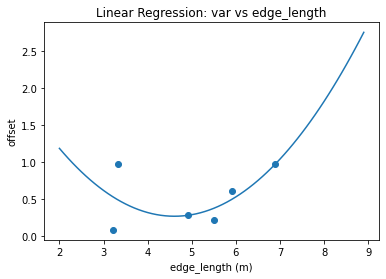

In [227]:
#What parameter are we fitting?
param = "var"

# define nb = number of bases = order of polynomial
nb = 2

#train
w = train_regression(nb, list(parameters_df["edge_length"]),list(parameters_df[param]) )
print("polynomial coeff:",w)

#create test edge_lengths
length_test = np.arange(2,9,0.1)
x = np.reshape(length_test,(-1,1))

#predict
basis = np.arange(nb+1)
A_test = x**basis
y_predict = A_test@w

#plot
plt.plot(length_test, y_predict)
plt.scatter( list(parameters_df["edge_length"]),list(parameters_df[param]) )
plt.xlabel("edge_length (m)")
plt.ylabel("offset")
plt.title(f"Linear Regression: {param} vs edge_length")